In [22]:
import os, shutil
from keras import layers
from keras import models
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle

from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True' #resolving issue with keras killing kernel

This is kaglle  Jellyfish Image Dataset (https://www.kaggle.com/datasets/anshtanwar/jellyfish-types/data).
This dataset contains 900 images of jellyfish belonging to six different categories and species: mauve stinger jellyfish, moon jellyfish, barrel jellyfish, blue jellyfish, compass jellyfish, and lion’s mane jellyfish. You can apply ML techniques to gain insights into jellyfish classification, species identification, and color analysis.

**Moon jellyfish (Aurelia aurita)**: Common jellyfish with four horseshoe-shaped gonads visible through the top of its translucent bell. It feeds by collecting medusae, plankton, and mollusks with its tentacles.
**Barrel jellyfish (Rhizostoma pulmo)**: Largest jellyfish found in British waters, with a bell that can grow up to 90 cm in diameter. It feeds on plankton and small fish by catching them in its tentacles.
**Blue jellyfish (Cyanea lamarckii)**: Large jellyfish that can grow up to 30 cm in diameter. It feeds on plankton and small fish by catching them in its tentacles.
**Compass jellyfish (Chrysaora hysoscella)**: Named after the brown markings on its bell that resemble a compass rose. It feeds on plankton and small fish by catching them in its tentacles.
**Lion’s mane jellyfish (Cyanea capillata)**: Largest jellyfish in the world, with a bell that can grow up to 2 meters in diameter and tentacles that can reach up to 30 meters in length. It feeds on plankton and small fish by catching them in its tentacles.
**Mauve stinger (Pelagia noctiluca)**: Small jellyfish with long tentacles and warty structures on its bell full of stinging cells. It feeds on other small jellyfish and oceanic sea squirts.

In [23]:
os.getcwd()

'C:\\Users\\Peter\\DataspellProjects\\kaggle\\jellyfish_image_classification'

In [24]:
TRAIN_DIR = 'C:/Users/Peter/DataspellProjects/kaggle/jellyfish_image_classification/data/Train_Test_Valid/Train'
TEST_DIR = 'C:/Users/Peter/DataspellProjects/kaggle/jellyfish_image_classification/data/Train_Test_Valid/test'
IMG_SIZE = 224# our images are 224x224x3


In [25]:
#Converting the output into one-hot format
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == 'barrel': return [1,0,0,0,0,0]
    elif word_label == 'blue': return [0,1,0,0,0,0]
    elif word_label == 'compass': return [0,0,1,0,0,0]
    elif word_label == 'lions': return [0,0,0,1,0,0]
    elif word_label == 'mauve': return [0,0,0,0,1,0]
    elif word_label == 'Moon': return [0,0,0,0,0,1]

In [26]:
#A function to read training images from folder
def create_train_data():
    training_data = []
    for fold in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(fold)
        path = TRAIN_DIR + '/' + fold
        # print(label)
        # print(path)
        files_names = os.listdir(path)
        for filename in files_names:
            path_img = path + '/' + filename
            img = cv2.imread(path_img,1)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])
            
        
    shuffle(training_data)
    train_images, train_labels = zip(*training_data)  # Разделяем изображения и метки

    return training_data

In [27]:
train_data = create_train_data()

100%|██████████| 6/6 [00:00<00:00,  8.19it/s]


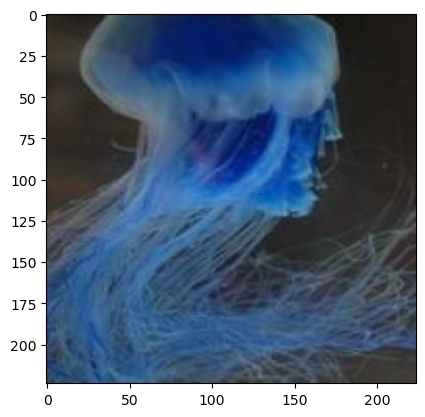

In [28]:
plt.imshow(train_data[0][0])

In [29]:
#A function to read training images from folder
def create_test_data():
    testing_data = []
    for fold in tqdm(os.listdir(TEST_DIR)):
        label = label_img(fold)
        path = TEST_DIR + '/' + fold
        # print(label)
        # print(path)
        files_names = os.listdir(path)
        for filename in files_names:
            path_img = path + '/' + filename
            img = cv2.imread(path_img,1)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img),np.array(label)])

    shuffle(testing_data)
    images, labels = zip(*testing_data)  # Разделяем изображения и метки


    return testing_data

In [30]:
# Creating a Sequential model
model = Sequential()
model.add(Conv2D(kernel_size=(3, 3), filters=32, activation='tanh', input_shape=(240, 240, 3)))
model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='tanh'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='tanh'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='tanh'))

model.add(Flatten())

model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    metrics=['acc'],
    optimizer='adam'
)


In [34]:
# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 238, 238, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 236, 236, 30)      8670      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 118, 118, 30)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 116, 116, 30)      8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 58, 58, 30)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 30)       

In [31]:
train_images, train_labels = zip(*train_data)  # Разделяем изображения и метки
train_labels

(array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0]),
 array([0, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 1, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 

In [32]:
X_train,X_val,y_train,y_val = train_test_split(train_images,train_labels,random_state=1)

In [33]:
# Training the model
history = model.fit(X_train,y_train,epochs=50,batch_size=50,validation_data=(X_val,y_val))

ValueError: Data cardinality is ambiguous:
  x sizes: 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224
  y sizes: 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6
Make sure all arrays contain the same number of samples.

In [ ]:
test_data = create_test_data()

In [ ]:
len(train_data)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Функция создания нейросети
def create_model(input_shape, num_classes):
    model = models.Sequential()

    # Слой свертки и пулинга
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Слой свертки и пулинга
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Слой свертки и пулинга
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Выравнивание данных для полносвязного слоя
    model.add(layers.Flatten())

    # Полносвязный слой
    model.add(layers.Dense(64, activation='relu'))

    # Выходной слой с функцией активации softmax для мультиклассификации
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Параметры
IMG_SIZE = 240
NUM_CLASSES = len(os.listdir(TRAIN_DIR))  # Количество классов
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Создание данных
training_data = create_train_data()

# Разделение данных на обучающую и тестовую выборки
images, labels = zip(*training_data)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Преобразование данных в формат, совместимый с нейросетью
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# Создание и компиляция модели
model = create_model(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


In [1]:
X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
#Splitting into Training and CV datasets
train = train_data[:750]
cv = train_data[750:]

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
cv_y = np.array([i[1] for i in cv])

In [ ]:
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = np.array([i[1] for i in test_data])

In [ ]:
print(X.shape)

In [ ]:
print(Y[2],type(Y[2]))

In [ ]:
cv_x.shape

In [ ]:
test_x.shape